# Evidence test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.data import make_dataloaders, save_model, DotDict
from models.VAE import VanillaVAE, IWAE, NeqVAE#, FlowVAE
from models.evidence import Estimator, NonEq_Estimator_w_a, AIS_Estimator
from utils.targets import Gaussian_target, Gaussian_mixture, Uniform, BNAF_examples

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
import pdb
%matplotlib inline

# Experiences Mixture of two Gaussian

## dim 5

In [3]:
### Fixing seed
seed = 54
np.random.seed(seed)
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torchType = torch.float32

In [4]:
args = DotDict()
args.h = 0.1 ###should be prop to sigma/dim ? 
args.gamma = -1.
args.name = 'DampedHamiltonian'# so far implemented : 'LeapFrog', 'DampedHamiltonian', 'Identity'
dim = 20
K = 10
#a, a_string = torch.tensor(np.exp(-1.*np.arange(K)*dim*args.gamma*args.h)), 'exp(-dim*gamma*h*range(K))'
a, a_string  = torch.ones(K), 'ones(K)'
args.estimation = True


argsp = DotDict()
argsp.mu = torch.zeros(dim)
argsp.cov = 2.*torch.eye(dim)
argsp.device = device
argsp.torchType=torchType
prior = torch.distributions.MultivariateNormal(loc=argsp.mu, covariance_matrix=argsp.cov)
importance_distr = torch.distributions.MultivariateNormal(loc=argsp.mu, covariance_matrix=argsp.cov)

In [5]:
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss//n_col
s= 1
u = torch.ones(dim)
#sigma=0.01
###create points
var_mix= .01
var_rest = 0.1
sigma_vec = torch.tensor([var_mix, var_mix]+ [var_rest]*(dim-2))
target_args.p_gaussians = [torch.tensor(.04)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (dim- 2), device = device, dtype = torchType) for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [sigma_vec*torch.eye(dim, device = device, dtype = torchType)]*target_args.num_gauss

#target_args.p_gaussians = [torch.tensor(.5)]*target_args.num_gauss
#target_args.locs = [-s*u, s*u]
#target_args.covs = [sigma*torch.eye(dim)]*target_args.num_gauss
logvar_p = np.log(7.)*torch.tensor(1.)
logvar_p_transfo = torch.tensor(0.)
n_test=500
target_args.dim=dim
target = Gaussian_mixture(target_args)
loglikelihood = lambda z, x=None: np.log(10) + (target.log_prob(z, x)).view(prior.log_prob(z).shape) - prior.log_prob(z).detach()

In [6]:
n_samples = 20000
est_naive = []
naive = Estimator(dim=dim, num_samples=n_samples*K, prior=prior, importance_distr=importance_distr)

for i in tqdm(range(n_test)):
    est_naive.append(naive.estimate(loglikelihood))


  0%|          | 0/100 [00:00<?, ?it/s]/home/achille/Documents/GitCodes/Non_equilibrium_VAE/NEO_code/utils/targets.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.mixture.log_prob(z) + torch.log(torch.tensor(torch.sum(self.pis)))
100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


In [7]:
est_infine_3 = []
args.gamma = -1.
non_eq_a = NonEq_Estimator_w_a(dim=dim, num_samples=n_samples, prior=prior, importance_distr=importance_distr, transformation_params=args, a=a,
                              logvar_p = logvar_p, logvar_p_transfo = logvar_p_transfo)

for i in tqdm(range(n_test)):
    est_infine_3.append(non_eq_a.estimate(loglikelihood))


100%|██████████| 100/100 [06:26<00:00,  3.87s/it]


In [8]:

args_ais = DotDict()
args_ais.name = 'LeapFrog'
args_ais.estimation = True
args_ais.h = 0.1
n_lf = 5
args_ais.N_LF = n_lf

est_ais = []
ais = AIS_Estimator(dim=dim, num_samples=n_samples, prior= prior, 
                    importance_distr=importance_distr, transformation_params=args_ais, K=1,
                   logvar_p = logvar_p)

for i in tqdm(range(1)):
    est_ais.append(ais.estimate(loglikelihood))


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [9]:
total_res = [est_naive, est_ais, est_infine_3]

In [10]:
median = np.array([np.median(item) for item in total_res])
q25 =  [np.quantile(item, 0.25) for item in total_res]
q75 =  [np.quantile(item, 0.75) for item in total_res]
err = np.array(q75)-np.array(q25)

TypeError: boxplot() got an unexpected keyword argument 'size'

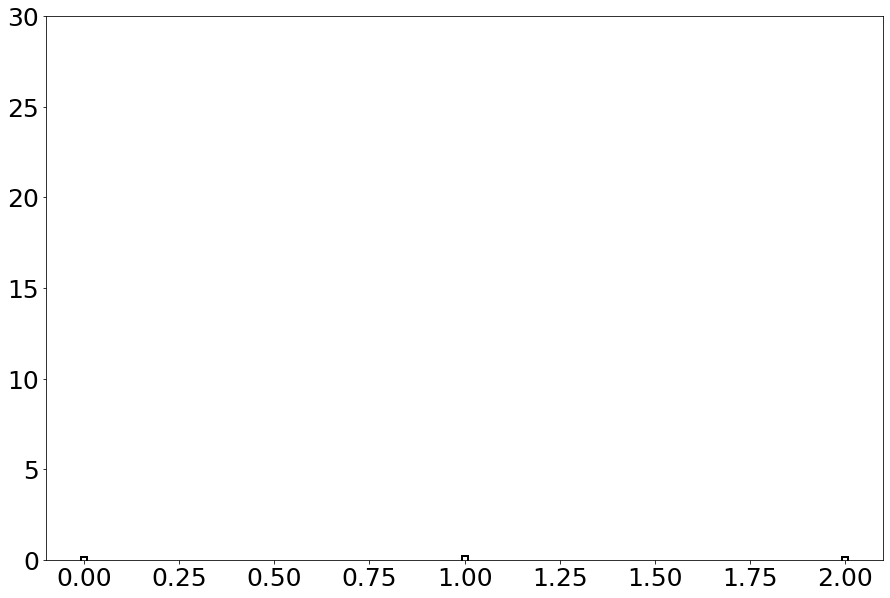

In [11]:
plt.figure(figsize = (15, 10))
plt.rcParams.update({'font.size': 25})
plt.ylim(0,30)

#sns.violinplot(data = total_res)
plt.errorbar(range(len(total_res)), median, yerr = err, color = 'black', ls = 'None', marker = 's', markeredgecolor = 'black',markerfacecolor = 'white', markeredgewidth = 2, linewidth = 2)

sns.boxplot(data = total_res, size = 3.5, dodge = True, alpha = .8)
plt.hlines(10, xmin = -0.5, xmax=5.5, color = 'red')

plt.xticks([0, 1, 2, 3, 4],['IS', 'AIS', r'InFiNE, $\gamma=0.3$',r'$\gamma=2$',r'$\gamma=4$'] )

plt.savefig('boxplot_two_gaussian_dim_5.pdf',bbox_inches='tight')